# Imports

In [ ]:
#uncomment if connected to colab instance instead of local instance
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install Ipython --upgrade 
# !pip install pyyaml h5py 
import sys 

In [ ]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj")

In [ ]:
import scipy.io
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date       
import tensorflow as tf
from datetime import date
import time
from ESS_utils_HA import *
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import imageio

In [ ]:
print(tf.__version__)

2.9.1


In [ ]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# NY ZONES

## Prep Work

In [ ]:
# DATA IMPORTS
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\NY_data\\"
RTP_NYC = np.array(scipy.io.loadmat(dir + "RTP_NYC_2010_2019.mat")['RTP'])
DAP_NYC = np.array(scipy.io.loadmat(dir + "DAP_NYC_2010_2019.mat")['DAP'])
RTP_LONGIL = np.array(scipy.io.loadmat(dir + "RTP_LONGIL_2010_2019.mat")['RTP'])
DAP_LONGIL = np.array(scipy.io.loadmat(dir + "DAP_LONGIL_2010_2019.mat")['DAP'])
RTP_NORTH = np.array(scipy.io.loadmat(dir + "RTP_NORTH_2010_2019.mat")['RTP'])
DAP_NORTH = np.array(scipy.io.loadmat(dir + "DAP_NORTH_2010_2019.mat")['DAP'])
RTP_WEST = np.array(scipy.io.loadmat(dir + "RTP_WEST_2010_2019.mat")['RTP'])
DAP_WEST = np.array(scipy.io.loadmat(dir + "DAP_WEST_2010_2019.mat")['DAP'])
  
RTP = RTP_NYC
DAP = DAP_NYC

### SET PARAMS HERE

In [ ]:
#Generating GT Value Functions
'''
Select dates: The data ends on 2019/12/31. We take the data range 2017/1/1 to 2018/12/31
'''

Ts = 1/12 # time step: 5min

# Last day for New England
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1 # 737789


start = date.toordinal(date(2017, 1, 1)) + 366 - 1 # 73669
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1 # 737424
startTest = date.toordinal(date(2019, 1, 1)) + 366 - 1
stopTest = date.toordinal(date(2019, 12, 31)) + 366 - 2
ind1 = (len(RTP_WEST[0])-lastDay+startTest-1)
ind2 = (len(RTP_WEST[0])-lastDay+stopTest+1)
T = int(((stop-start+1)*24/Ts)) # T: 210240, MATLAB: 210240

# tlambda: real time price over time period t
tlambda = RTP[:, (len(RTP[0])-lastDay+start-2):(len(RTP[0])-lastDay+stop+1)] # (288, 731)
tlambda = tlambda.flatten('F')
# tlambda_DA: day ahead price over time period t
tlambda_DA = DAP[:, (len(DAP[0])-lastDay+start-2):(len(DAP[0])-lastDay+stop+1)] # (288, 731)
print(len(DAP[0])-lastDay+start-2)
print(len(DAP[0])-lastDay+stop+1)
print(tlambda_DA.shape)
tlambda_DA = tlambda_DA.flatten('F') # (210528,)
T_CNN = 104820 - 288

'''
Set parameters
'''
Pr = 1/2 # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
P = Pr*Ts  # actual power rating taking time step size into account, 0.5*1/12 = 0.041666666666666664
eta = .9  # efficiency
c = 10  # marginal discharge cost - degradation
ed = 0.001  # SoC sample granularity
ef = .5  # final SoC target level, use 0 if none (ensure that electric vehicles are sufficiently charged at the end of the period)
Ne = math.floor(1/ed)+1  # number of SOC samples, (1/0.001)+1=1001
e0 = .5  # Beginning SoC level


'''
Downsample settings
'''
num_segment = 10

2556
3288
(288, 732)


In [ ]:
#for later evaluation 
rtp_NYC = RTP_NYC[:, ind1:ind2].flatten('F')
rtp_LONGIL = RTP_LONGIL[:, ind1:ind2].flatten('F')
rtp_NORTH = RTP_NORTH[:, ind1:ind2].flatten('F')
rtp_WEST = RTP_WEST[:, ind1:ind2].flatten('F')

In [ ]:
#counting negative price instances
print(np.sum(rtp_NYC  < 0, axis=0))
print(np.sum(rtp_LONGIL  < 0, axis=0))
print(np.sum(rtp_NORTH < 0, axis=0))
print(np.sum(rtp_WEST  < 0, axis=0))

208
190
6334
633


In [ ]:
#price volatility of zone
print(np.std(rtp_NYC))
print(np.std(rtp_LONGIL))
print(np.std(rtp_NORTH))
print(np.std(rtp_WEST))

28.825748992423915
50.17065848005814
40.25960910461724
37.550728586236865


### 5 Min Valuation

In [ ]:
#GENERATING GT VALUE FUNCTION FOR TRAINING
vAvg = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, tlambda)[1]

Time: 34.94457149505615


In [ ]:
T = rtp_NYC.shape[0] - 288 #number of time steps for gt testing value functions
# print(T)

In [ ]:
#generating test value functions to calculate benchmark profits 5 min valuation
vAvg_NYC = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, rtp_NYC)[1]
vAvg_LONGIL = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, rtp_LONGIL)[1]
vAvg_NORTH = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, rtp_NORTH)[1]
vAvg_WEST = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, rtp_WEST)[1]

Time: 13.315172910690308


### Plotting Raw Profits

In [ ]:
#to show how profit scales with number of segments for different storage duration
num = [1000, 500, 250, 100, 50, 25, 10, 5, 1]
Pr = [1/2, 1/4, 1/12, 1/72]
profits = np.zeros((int(len(num)*len(Pr)),))
T = rtp_WEST.shape[0] - 288
i = 0
for p in Pr:
  for n in num:
    P = p*Ts
    vAvg_WEST = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, n, rtp_WEST)[1]
    print('\n' + str(int(1/p)) + 'hr WEST OPTIMAL ' + str(n) + ' :')
    profits[i] = evaluate_using_v(rtp_WEST[12:], vAvg_WEST[:, 12:], 
                    eta, c, T_CNN,
                    Ts, p)
    i += 1

In [ ]:
#calculating profit ratios for above^
prf = profits.reshape((int(len(Pr)), int(len(num))))
prfmax = prf[:, 0]

prfrat = np.zeros_like(prf)
for i, curr in enumerate(prfmax):
  prfrat[i, :] = prf[i, :]/curr
print(prfrat)

[[1.         0.99962591 0.99717546 0.99044757 0.98353598 0.97413301
  0.88729927 0.82134207 0.91706893]
 [1.         0.99792255 0.99360049 0.98563964 0.97769499 0.9305496
  0.86022532 0.79197733 0.91930756]
 [1.         0.99259779 0.9782089  0.94981493 0.91888064 0.87400827
  0.81016298 0.75106798 0.93015616]
 [1.         0.9629603  0.91474343 0.85274379 0.80188471 0.75014084
  0.70887816 0.68163955 0.86630522]]


In [ ]:
print(num[:-1])

[1000, 500, 250, 100, 50, 25, 10, 5]


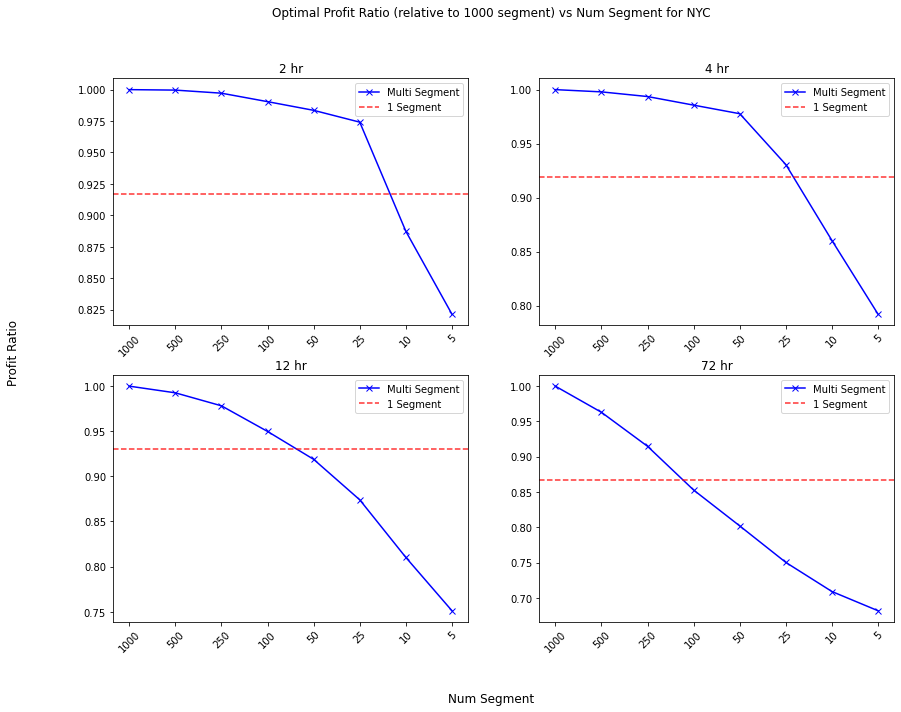

In [ ]:
fig, axs = plt.subplots(2, 2)
x = [1,2,3,4,5,6,7,8]
axs[0, 0].plot(x, prfrat[0, :-1], marker='x', color='b', label='Multiseg')
axs[0 ,0].axhline(y=prfrat[0,-1], color='r', linestyle='--', label='1Seg', alpha=0.8)
axs[0, 0].set_title(str(int(Pr[0]**-1)) + ' hr')
axs[0, 1].plot(x, prfrat[1, :-1],  marker='x', color='b', label='Multiseg')
axs[0 ,1].axhline(y=prfrat[1,-1], color='r', linestyle='--', label='1Seg',alpha=0.8)
axs[0, 1].set_title(str(int(Pr[1]**-1)) + ' hr')
axs[1, 0].plot(x, prfrat[2, :-1],  marker='x', color='b', label='Multiseg')
axs[1 ,0].axhline(y=prfrat[2,-1], color='r', linestyle='--', label='1Seg',alpha=0.8)
axs[1, 0].set_title(str(int(Pr[2]**-1)) + ' hr')
axs[1, 1].plot(x, prfrat[3, :-1],  marker='x', color='b', label='Multiseg')
axs[1 ,1].axhline(y=prfrat[3,-1], color='r', linestyle='--', label='1Seg',alpha=0.8)
axs[1, 1].set_title(str(int(Pr[3]**-1)) + ' hr')
fig.suptitle('Optimal Profit Ratio (relative to 1000 segment) vs Num Segment for NYC')
fig.set_size_inches(14, 10)
for ax in axs.flat:
    # ax.set_xscale('symlog')
    ax.set_xticks(x, num[:-1], rotation=45)
    ax.legend(['Multi Segment', '1 Segment'])
    # ax.invert_xaxis()
fig.supxlabel('Num Segment')
fig.supylabel('Profit Ratio')
fig.savefig('C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\rawprof.png', dpi=100)

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

## Training

### RTP + DAP

In [ ]:
#Training + Parameter Control
num_DAP = 24
num_RTP = 36
#setting test dir info
#for github users, set folder to the directory 
#where the zip file is extracted
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'

region = 'NY'
test = 'CNN_LSTM_' + str(num_segment) +'_0.5_HA'
net = 't1' #set string as t1 or vanilla based on which model you want


# uncomment below to generate training set 
X, y = generate_train_CNN(T, DAP, tlambda, 
                          start, stop, lastDay, 
                          num_DAP, num_RTP, vAvg)
X = np.asarray(X)
y = np.asarray(y)
x_train, x_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.05, shuffle=True)

model = val_CNN_LSTM(output_size=num_segment, net=net)
# model.summary()

ytrain shape 3503.8
datpoints shape 3503
3503
(60, 60, 1)
(60, 10, 1)


In [ ]:
curr_run = net + '_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'
checkpoint_path = folder + region + '_tests\\' + test + '\\' + curr_run

#checkpoint path below w extreme was checking different data scarcity scenarios
#ie when we have only 3d, 1w, 1m, 6m, 1yr of data 
# checkpoint_path = folder + region + '_tests\\' + test + '\\extreme\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


epochs = 100
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  monitor='val_loss', verbose=1, 
#                                                  save_best_only=True, mode='min')

# history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
#                     verbose=1, shuffle =True,
#                     callbacks=[cp_callback])
cb = TimeHistory()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[ cb])

Epoch 1/100
104/104 [==============================] - 14s 59ms/step - loss: 1266.7410 - mse: 1266.7408 - mae: 20.9368 - val_loss: 3242.4321 - val_mse: 3242.4319 - val_mae: 17.2154
Epoch 2/100
104/104 [==============================] - 4s 39ms/step - loss: 887.7477 - mse: 887.7477 - mae: 13.6124 - val_loss: 3081.9126 - val_mse: 3081.9128 - val_mae: 16.0803
Epoch 3/100
104/104 [==============================] - 4s 37ms/step - loss: 826.0004 - mse: 826.0009 - mae: 12.8397 - val_loss: 3004.6953 - val_mse: 3004.6956 - val_mae: 14.3128
Epoch 4/100
104/104 [==============================] - 4s 38ms/step - loss: 747.7903 - mse: 747.7903 - mae: 11.3623 - val_loss: 2842.5764 - val_mse: 2842.5764 - val_mae: 11.8980
Epoch 5/100
104/104 [==============================] - 4s 38ms/step - loss: 653.7182 - mse: 653.7182 - mae: 9.5302 - val_loss: 2750.4858 - val_mse: 2750.4858 - val_mae: 11.3363
Epoch 6/100
104/104 [==============================] - 4s 37ms/step - loss: 603.7266 - mse: 603.7266 - mae: 

In [ ]:
times = cb.times
print(sum(times[:]))

390.7284924983978


In [ ]:
#training plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])

#### visualizing training


In [ ]:
plt.close('all')

In [ ]:
#code below for generating gif of training
plt.close('all')
model = val_CNN_LSTM(output_size=num_segment, net='t1')
optprof = 24668
num_RTP =36
num_DAP = 24
giflist = []
#sets time step that you want to generate output for
t = 24 #stable price time
#t=128 #price spike
region = 'NY'
for n in np.arange(1, 46):
  dir = folder + region + '_tests\\vis\\' + str(n) + '.hdf5'
  print(dir)
  model.load_weights(dir)
  pred = predictor(model, DAP_WEST, RTP_WEST, 
                                      startTest, stopTest, lastDay, 
                                      num_DAP, num_RTP, Pr=Pr)
  #uncomment below for saving vector of data for plotting in matlab
  # scipy.io.savemat(folder + region + '_tests\\vis\\mats\\pred_' + str(n) + 't' + str(t) + '.mat', {'pred'+str(n)+'_'+str(t):pred[:, t-12]})
  # scipy.io.savemat(folder + region + '_tests\\vis\\mats\\true_' + str(n) + 't' + str(t) + '.mat', {'true'+str(n)+'_'+str(t):vAvg_WEST[:, t]})
  #below code generates plot and saves to make gif
  plt.figure()
  # plt.text(0,10,str(round(rat,2)), fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))
  plt.ylim(15)
  plt.plot(np.arange(0,1,0.1), vAvg_WEST[:, t])
  plt.plot(np.arange(0,1,0.1), pred[:, t-12])
  plt.xlabel('SoC')
  plt.ylabel('dV/dt')
  plt.title('Value Function for West 2019, t='+str(t)+ ' , checkpoint ' + str(n))
  plt.legend(['Ground Truth', 'Prediction'])
  plt.savefig(folder + region + '_tests\\vis\\' + str(n) + '_' + str(t) + '_2.png')
  plt.close()

  giflist.append(folder + region + '_tests\\vis\\' + str(n) + '_' + str(t) + '_2.png')

In [ ]:
print(np.arange(0,1,0.1))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [ ]:
#makes and saves gif
with imageio.get_writer(folder + region + '_tests\\vis\\t_' + str(t) + '_2.gif', mode='I') as writer:
    for filename in giflist:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\Yousuf Baker\AppData\Local\Temp\ipykernel_31844\2134491341.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


### RTP ONLY (for QNSLND Transfer Learning)


In [ ]:
#Training + Parameter Control

num_RTP=60
X, y = generate_train_CNN_RTP(T, tlambda, 
                              start, stop, lastDay,
                              num_RTP, vAvg)
X = np.asarray(X)
y = np.asarray(y)

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.05, 
                                                  shuffle=True)
model = val_CNN_LSTM(output_size=num_segment, t1=True)
model.summary()

#setting test dir info
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'
region = 'NY'
test = 'CNN_LSTM_' + str(num_segment) +'_12hr_HA_RTP'

In [ ]:
#loading weights of best previously trained model
model_name = 't1_best_model_epoch70_loss72.03975.hdf5'
dir = folder + zone + '_tests\\' + test + '\\' + model_name
model.load_weights(dir)

In [ ]:
curr_run = 't1_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'
checkpoint_path = folder + region + '_tests\\' + test + '\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


epochs = 100
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback])

## Evaluation 5 min valuation 5 min Arbitrage



In [ ]:
#loading weights of best previously trained model
#set up model in RTP+DAP tab under training
model_name = net + '_best.hdf5'
# dir = folder + region + '_tests\\' + test + '\\' + model_name
dir = folder + region + '_tests\\' + test + '\\extreme\\' + model_name
model.load_weights(dir)

In [ ]:
# CNNLSTM evaluate function automatically extracts unseen test data from
# full data vector
# need to run this to extract 5 min value prediction for later downsampling
# and hour prediction
print('NYC PREDICTED:')
v1_NYC, arb1_NY, _ = CNNLSTM_evaluate(model, DAP_NYC, RTP_NYC, 
                                    startTest, stopTest, lastDay,
                                    num_DAP, num_RTP, Pr=Pr)
print('\nLONGIL PREDICTED:')
v1_LONGIL, arb1_LONGIL, _  = CNNLSTM_evaluate(model, DAP_LONGIL, RTP_LONGIL, 
                                          startTest, stopTest, lastDay, 
                                          num_DAP, num_RTP, Pr=Pr)
print('\nNORTH PREDICTED:')
v1_NORTH, arb1_NORTH, _ = CNNLSTM_evaluate(model, DAP_NORTH, RTP_NORTH, 
                                        startTest, stopTest, lastDay, 
                                        num_DAP, num_RTP, Pr=Pr)
print('\nWEST PREDICTED:')
v1_WEST, arb1_WEST, _ = CNNLSTM_evaluate(model, DAP_WEST, RTP_WEST, 
                                      startTest, stopTest, lastDay, 
                                      num_DAP, num_RTP, Pr=Pr)
#function outputs T_CNN, but to avoid having to run this everytime, T_CNN is
  #also declared in prep work

In [ ]:
'''
optimal profits to beat, T_CNN is received from CNNLSTM_evaluate function to 
make sure that the optimal and prediction are evaluated for the same time steps
'''
print('NYC OPTIMAL:')

evaluate_using_v(rtp_NYC[12:], vAvg_NYC[:, 12:], 
                 eta, c, T_CNN,
                 Ts, Pr)
print('\nLONGIL OPTIMAL:')
evaluate_using_v(rtp_LONGIL[12:], vAvg_LONGIL[:, 12:], 
                 eta, c, T_CNN,
                 Ts, Pr)
print('\nNORTH OPTIMAL:')
evaluate_using_v(rtp_NORTH[12:], vAvg_NORTH[:, 12:], 
                 eta, c, T_CNN,
                 Ts, Pr)
print('\nWEST OPTIMAL:')
evaluate_using_v(rtp_WEST[12:], vAvg_WEST[:, 12:], 
                 eta, c, T_CNN,
                 Ts, Pr)

NYC OPTIMAL:
2856
3704
85
Time: 7.190615892410278

LONGIL OPTIMAL:
5186
6430
124
Time: 7.1306140422821045

NORTH OPTIMAL:
2843
3892
105
Time: 7.140904903411865

WEST OPTIMAL:
5175
6388
121
Time: 7.131850004196167


5174.6315777112795

### upsampling step for 10 segment

In [ ]:
#predictions

print('NYC PREDICTED:')
v1_NYC, arb1_NY, _ = CNNLSTM_evaluate(model, DAP_NYC, RTP_NYC, 
                                    startTest, stopTest, lastDay,
                                    num_DAP, num_RTP, Pr=Pr, rebin=10)
print('\nLONGIL PREDICTED:')
v1_LONGIL, arb1_LONGIL, _  = CNNLSTM_evaluate(model, DAP_LONGIL, RTP_LONGIL, 
                                          startTest, stopTest, lastDay, 
                                          num_DAP, num_RTP, Pr=Pr, rebin=10)
print('\nNORTH PREDICTED:')
v1_NORTH, arb1_NORTH, _ = CNNLSTM_evaluate(model, DAP_NORTH, RTP_NORTH, 
                                        startTest, stopTest, lastDay, 
                                        num_DAP, num_RTP, Pr=Pr, rebin=10)
print('\nWEST PREDICTED:')
v1_WEST, arb1_WEST, _ = CNNLSTM_evaluate(model, DAP_WEST, RTP_WEST, 
                                      startTest, stopTest, lastDay, 
                                      num_DAP, num_RTP, Pr=Pr, rebin=10)

NYC PREDICTED:
Evaluating using X_test
Profit:  9969
Revenue:  12878
291
Time: 22.18666434288025

LONGIL PREDICTED:
Evaluating using X_test


KeyboardInterrupt: ignored

# ERCOT: HOUSTON

## Prep Work

In [ ]:
# Houston Data 2016/2017 for training
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\TX_data\\2015\\"
RTP_H = pd.read_csv(dir + 'RTP.csv')
DAP_H = pd.read_csv(dir + 'DAP.csv')
RTP_H = np.asarray(RTP_H['Settlement Point Price'])
print(RTP_H.shape)
DAP_H = np.asarray(DAP_H['Settlement Point Price'])
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\TX_data\\2016\\"
RTP_H1 = pd.read_csv(dir + 'RTP.csv')
DAP_H1 = pd.read_csv(dir + 'DAP.csv')
RTP_H1 = np.asarray(RTP_H1['Settlement Point Price'])
DAP_H1 = np.asarray(DAP_H1['Settlement Point Price'])
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\TX_data\\2017\\"
RTP_H2 = pd.read_csv(dir + 'RTP.csv')
DAP_H2 = pd.read_csv(dir + 'DAP.csv')
RTP_H2 = np.asarray(RTP_H2['Settlement Point Price'])
DAP_H2 = np.asarray(DAP_H2['Settlement Point Price'])
# RTP = np.concatenate(( RTP_H1, RTP_H2))
# DAP = np.concatenate((DAP_H1, DAP_H2))
RTP = np.concatenate((RTP_H, RTP_H1, RTP_H2))
DAP = np.concatenate((DAP_H, DAP_H1, DAP_H2))

(35040,)


In [ ]:
#Houston Data 2018 for testing
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\TX_data\\2018\\"
RTP_H_test = pd.read_csv(dir + 'RTP.csv')
DAP_H_test = pd.read_csv(dir + 'DAP.csv')
RTP_H_test = np.asarray(RTP_H_test['Settlement Point Price'])
DAP_H_test = np.asarray(DAP_H_test['Settlement Point Price'])

In [ ]:
print(np.sum(RTP_H_test  < 0, axis=0))
print(np.std(RTP_H_test))

124
76.51750084516668


In [ ]:
# SETTING PARAMETERS AND PRE-PROCESSING PRICE
#below doesn't apply to houston, but needs to be loaded for later functions to
# work even if not used
# Last day for New England
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1 # 737789


start = date.toordinal(date(2017, 1, 1)) + 366 - 1 # 73669
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1 # 737424
startTest = date.toordinal(date(2019, 1, 1)) + 366 - 1
stopTest = date.toordinal(date(2019, 12, 31)) + 366 - 2

'''
Set parameters
'''
Ts = 1/4 # time step: 5min
Pr = 1/12  # normalized power rating wrt energy rating 
P = Pr*Ts  # actual power rating taking time step size into account
eta = .9  # efficiency
c = 10  # marginal cost
ed = .001  # SoC sample granularity
ef = .5  # final SoC target level, use 0 if none
Ne = math.floor(1/ed)+1  # number of SOC samples
e0 = .5  # Beginning SoC level


'''
Downsample settings
'''
num_segment = 1

In [ ]:
print(RTP.shape)
print(RTP_H_test.shape)

(105216,)
(35040,)


In [ ]:
#for training
# T = int(len(RTP) - (24/Ts))
# vAvg_H = generate_value_function(Ts, P, eta, c, 
#                                  ed, ef, Ne, T, 
#                                  num_segment, RTP.flatten('F'))[1]
#for generating optimal profit for becnhmarking
Ttest = int(len(RTP_H_test) - (24/Ts))
vAvg_H_test = generate_value_function(Ts, P, eta, c, 
                                 ed, ef, Ne, Ttest, 
                                 num_segment, RTP_H_test.flatten('F'))[1]

Time: 4.537904262542725


In [ ]:
print(vAvg_H.shape)
print(vAvg_H_test.shape)

## Training


In [ ]:
#Training + Parameter Control
num_RTP= 20 
num_DAP= 18
#setting test dir info
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'
region = 'TX'
test = 'CNN_LSTM_' + str(num_segment) +'_12hr_HA'
net = 't1'
# T_H = int(RTP.shape[0]-24/Ts)
# X, y = generate_train_CNN(T_H, DAP, RTP, 
#                           start, stop, lastDay, 
#                           num_DAP, num_RTP, vAvg_H, 
#                           TX=True, Ts=Ts)
# X = np.asarray(X)
# y = np.asarray(y)
# x_train, x_val, y_train, y_val = train_test_split(X, y, 
#                                                   test_size=0.05, shuffle=True)
# #set t1 to true or false depending on whether you want to instantiate t1 
# #or vanilla model
model = val_CNN_LSTM(input_size = (int(num_RTP+num_DAP), int(num_RTP+num_DAP), 1), 
                     output_size=num_segment, net=net, step=int(num_RTP+num_DAP))
# model.summary()

In [ ]:
curr_run = net + '_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'
checkpoint_path = folder + region + '_tests\\' + test + '\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


epochs = 100
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback])

## Evaluation

In [ ]:
#load best model weights
model_name = net + '_best.hdf5'
dir = folder + region + '_tests\\' + test + '\\' + model_name
model.load_weights(dir)

In [ ]:
#extracting value function from CNNLSTM_evaluate function
v_H1, _, T_CNN = CNNLSTM_evaluate(model, DAP_H_test, RTP_H_test, 
                                    startTest, stopTest, lastDay, 
                                    num_DAP, num_RTP, TX=True, Pr=Pr, Ts=Ts)

Evaluating using X_test
Profit:  8665
Revenue:  9663
100
Time: 3.4381425380706787


In [ ]:
#upsampled
v_H1u, _, T_CNN = CNNLSTM_evaluate(model, DAP_H_test, RTP_H_test, 
                                    startTest, stopTest, lastDay, 
                                    num_DAP, num_RTP, TX=True, Pr=Pr, Ts=Ts,
                                  rebin=10)

Evaluating using X_test
Profit:  4329
Revenue:  4912
58
Time: 6.232747793197632


In [ ]:
print('HOUSTON OPTIMAL:')
evaluate_using_v(RTP_H_test[4:], vAvg_H_test[:,4:], 
                 eta, c, T_CNN, Ts, Pr=Pr)

HOUSTON OPTIMAL:
25633
28255
262
Time: 1.6602451801300049


25633.326580555557

# QUEENSLAND

## Prep Work

In [ ]:
#Queensland Data 2019 for training
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\QNSLND_data\\"
RTP_Q = pd.read_csv(dir + 'RTP_2019.csv')
RTP_Q = np.asarray(RTP_Q['energyPrice'])
RTP_Q = RTP_Q*0.6954 #average exchange rate to USD in 2019

In [ ]:
#Queensland Data 2021 for testing
RTP_Q_test = pd.read_csv(dir + 'RTP_2021.csv')
RTP_Q_test = np.asarray(RTP_Q_test['Energy Price ($/MWh)'])
RTP_Q_test = RTP_Q_test*0.7513 #average exchange rate to USD in 2021

In [ ]:
print(np.sum(RTP_Q_test  < 0, axis=0))
print(np.std(RTP_Q_test))

522
243.00554623701174


In [ ]:
# Last day for New England
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1 # 737789


start = date.toordinal(date(2017, 1, 1)) + 366 - 1 # 73669
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1 # 737424
startTest = date.toordinal(date(2019, 1, 1)) + 366 - 1
stopTest = date.toordinal(date(2019, 12, 31)) + 366 - 2
'''
Set parameters
'''
Ts = 1/12 # time step: 5min
Pr = 1/12 # normalized power rating wrt energy rating 
P = Pr*Ts  # actual power rating taking time step size into account
eta = .9  # efficiency
c = 10  # marginal cost
ed = .001  # SoC sample granularity
ef = .5  # final SoC target level, use 0 if none
Ne = math.floor(1/ed)+1  # number of SOC samples
e0 = .5  # Beginning SoC level


'''
Downsample settings
'''
num_segment = 10

In [ ]:
#for transfer learning
Ttrain = 288*7+12 #number of days used in training, set this according to mode
# Ttrain = len(RTP_Q.flatten('F'))-288
vAvg_Q = generate_value_function(Ts, P, eta, c, 
                                 ed, ef, Ne, Ttrain, 
                                 num_segment, RTP_Q.flatten('F'))[1]
#for generating optimal profit for becnhmarking
# Ttest = int(len(RTP_Q_test.flatten('F'))-288)
# vAvg_Q_test = generate_value_function(Ts, P, eta, c, 
#                                  ed, ef, Ne, Ttest, 
#                                  num_segment, RTP_Q_test.flatten('F'))[1]

Time: 0.23086953163146973


In [ ]:
print(Ttrain)

102816


## Transfer Learning

In [ ]:
#Training + Parameter Control
# T_Q = 102792 #using all days in training set (1 year)
#modes below for saving model for different data scarcity scenarios
modes = ['3d', '1w', '1m', '6m', '1y'] #for training from scratch
# modes = ['tl_3d', 'tl_1w', 'tl_1m', 'tl_6m', 'tl_1y'] #for transfer learning
mode = modes[0] #pick mode based on how many months/days you want
# T_Q = Ttrain-12
num_RTP=60
#setting test dir info
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'

region = 'QNSLND'
test = 'CNN_LSTM_' + str(num_segment) +'_12hr_HA_RTP'
net = 't1'

# X, y = generate_train_CNN_RTP(T_Q, RTP_Q.flatten('F'), 
#                               start, stop, lastDay, 
#                               num_RTP, vAvg_Q)
# X = np.asarray(X)
# y = np.asarray(y)

# x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.05, 
#                                                   shuffle=True)
model = val_CNN_LSTM(output_size=num_segment, net=net)
# model.summary()

In [ ]:
#ONLY RUN THIS CELL IF YOU ARE TRANSFER LEARNING
# Note transfer learning here uses only RTP model from NY zone
dir = folder + 'NY_tests\\' + test + '\\' + net + '_best.hdf5'
print(dir)
#freezing all weights save for last dense layer (-3 bc reshapes after dense)
model.load_weights(dir)
for layer in model.layers[:-3]:
    layer.trainable = False

C:\Users\Yousuf Baker\Desktop\ESS_proj\NY_tests\CNN_LSTM_10_12hr_HA_RTP\t1_best.hdf5


In [ ]:
curr_run = net + '_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'

checkpoint_path = folder + region + '_tests\\' + test + '\\'+ mode + '\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


# epochs =  25 #TL
epochs = 100 #no TL
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')
cb = TimeHistory()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback, cb])

In [ ]:
#calculate convergence time (time to last epoch v.error improved/model saved)
#you can read the above from the directory where weights are saved 
times = cb.times
print(sum(times[:]))

102.20420956611633


## Evaluation

In [ ]:
#load best model weights from rest
model_name = net + '_best.hdf5'

dir = folder + region + '_tests\\' + test + '\\'+ mode + '\\' + model_name
model.load_weights(dir)
print(dir)

C:\Users\Yousuf Baker\Desktop\ESS_proj\QNSLND_tests\CNN_LSTM_10_12hr_HA_RTP\3d\t1_best.hdf5


In [ ]:
print('QUEENSLAND PREDICTED:')
vR_Q, arbR_Q, T_CNN = CNNLSTM_evaluate_RTP(model, RTP_Q_test, 
                                    startTest, stopTest, lastDay, 
                                    num_RTP, Q=True, Pr=Pr)

QUEENSLAND PREDICTED:
Evaluating using X_test
Profit:  2761
Revenue:  3039
28
Time: 3.6348459720611572


In [ ]:
print('QUEENSLAND PREDICTED UPSAMPLE:')
vR_Q, arbR_Q, T_CNN = CNNLSTM_evaluate_RTP(model, RTP_Q_test, 
                                    startTest, stopTest, lastDay, 
                                    num_RTP, Q=True, Pr=Pr, rebin=10)

QUEENSLAND PREDICTED UPSAMPLE:
Evaluating using X_test
Profit:  2709
Revenue:  3026
32
Time: 9.305375099182129


In [ ]:
num_RTP = 60
print('QUEENSLAND OPTIMAL:')
evaluate_using_v(RTP_Q_test[12:], vAvg_Q_test[:,12:],
                 eta, c, T_CNN, Ts=Ts, Pr=Pr)

QUEENSLAND OPTIMAL:
16993
18336
134
Time: 2.265115976333618


16992.880776092203

# CALIFORNIA: WALNUT

In [ ]:
#CAL Data
# DATA IMPORTS
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\CAL_data\\"
dat = scipy.io.loadmat(dir + "WALNUT.mat")
RTPC = dat['Q']
RTP_C = RTPC[:,(-365*2):(-365)].flatten('F')
#testing
RTP_C_test = RTPC[:,-365:].flatten('F')

In [ ]:
print(np.sum(RTP_C_test  < 0, axis=0))
print(np.std(RTP_C_test))

3286
55.546383634017296


## Prep Work

In [ ]:
# Last day for New England
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1 # 737789


start = date.toordinal(date(2017, 1, 1)) + 366 - 1 # 73669
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1 # 737424
startTest = date.toordinal(date(2019, 1, 1)) + 366 - 1
stopTest = date.toordinal(date(2019, 12, 31)) + 366 - 2
'''
Set parameters
'''
Ts = 1/12 # time step: 5min
Pr = 1/12 # normalized power rating wrt energy rating 
P = Pr*Ts  # actual power rating taking time step size into account
eta = .9  # efficiency
c = 10  # marginal cost
ed = .001  # SoC sample granularity
ef = .5  # final SoC target level, use 0 if none
Ne = math.floor(1/ed)+1  # number of SOC samples
e0 = .5  # Beginning SoC level


'''
Downsample settings
'''
num_segment = 10

In [ ]:
#for transfer learning
# Ttrain = len(RTP_C.flatten('F')) - 288
Ttrain = 288*3+12
vAvg_C = generate_value_function(Ts, P, eta, c, 
                                 ed, ef, Ne, Ttrain, 
                                 num_segment, RTP_C.flatten('F'))[1]
# for generating optimal profit for becnhmarking
# Ttest = int(len(RTP_C_test.flatten('F'))-288)
# vAvg_C_test = generate_value_function(Ts, P, eta, c, 
#                                  ed, ef, Ne, Ttest, 
#                                  num_segment, RTP_C_test.flatten('F'))[1]

Time: 0.2336432933807373


In [ ]:
print(np.std(RTP_C[:288*3+12]))
print(np.sum(RTP_C[:288*3+12]  < 0, axis=0))
print(np.std(RTP_C))
print(np.sum(RTP_C  < 0, axis=0))

66.52669176326495
0
51.833098678923285
4346


## Transfer Learning

In [ ]:
#Training + Parameter Control
# T_C = 102792 #choosing days for queensland training, full
# modes = ['3d', '1w', '1m', '6m', '1y']
modes = ['tl_3d', 'tl_1w', 'tl_1m', 'tl_6m', 'tl_1y']
mode = modes[4]
# T_C = Ttrain-12
num_RTP=60
#setting test dir info
folder = 'C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\'

region = 'CAL'
test = 'CNN_LSTM_' + str(num_segment) +'_12hr_HA_RTP'
net = 't1'

# X, y = generate_train_CNN_RTP(T_C, RTP_C.flatten('F'), 
#                               start, stop, lastDay, 
#                               num_RTP, vAvg_C)
# X = np.asarray(X)
# y = np.asarray(y)

# x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.05, 
#                                                   shuffle=True)
model = val_CNN_LSTM(output_size=num_segment, net=net)
# model.summary()

In [ ]:
# Note transfer learning here uses only RTP model from NY zone
dir = folder + 'NY_tests\\' + test + '\\' + net + '_best.hdf5'
#freezing all weights save for last dense layer (-3 bc reshapes after dense)
model.load_weights(dir)
for layer in model.layers[:-3]:
    layer.trainable = False

In [ ]:
curr_run = net + '_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5'

checkpoint_path = folder + region + '_tests\\' + test + '\\'+ mode + '\\' + curr_run

#uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=10,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


# epochs =  25 #TL
epochs = 100 #no TL
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')
cb = TimeHistory()
# t = time.time()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback, cb])
# history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
#                     verbose=1, shuffle =True,
#                     callbacks=[cb])
# print("TIME TAKEN TO TRAIN: ", time.time() - t)

In [ ]:
print(checkpoint_path)

C:\Users\Yousuf Baker\Desktop\ESS_proj\CAL_tests\CNN_LSTM_10_0.5_HA_RTP\tl_1w\t1_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.hdf5


## Evaluation

In [ ]:
#load best model weights from transfer learning full
# model_name = net + '_best.hdf5'
#load best model weights from rest
model_name = net + '_best.hdf5'

dir = folder + region + '_tests\\' + test + '\\'+ mode + '\\' + model_name
model.load_weights(dir)
print(dir)

C:\Users\Yousuf Baker\Desktop\ESS_proj\CAL_tests\CNN_LSTM_10_12hr_HA_RTP\tl_1y\t1_best.hdf5


In [ ]:
print('WALNUT PREDICTED:')
vR_Q, arbR_Q, T_CNN = CNNLSTM_evaluate_RTP(model, RTP_C_test, 
                                    startTest, stopTest, lastDay, 
                                    num_RTP, Q=True, Pr=Pr)

WALNUT PREDICTED:
Evaluating using X_test
Profit:  3918
Revenue:  4752
83
Time: 7.50846529006958


In [ ]:
print('WALNUT PREDICTED UPSAMPLE:')
vR_Q, arbR_Q, T_CNN = CNNLSTM_evaluate_RTP(model, RTP_C_test, 
                                    startTest, stopTest, lastDay, 
                                    num_RTP, Q=True, Pr=Pr, rebin=10)

WALNUT PREDICTED UPSAMPLE:
Evaluating using X_test
Profit:  4558
Revenue:  5654
110
Time: 22.016329288482666


In [ ]:
num_RTP = 60
print('WALNUT OPTIMAL:')
evaluate_using_v(RTP_C_test[12:], vAvg_C_test[:,12:],
                 eta, c, T_CNN, Ts=Ts, Pr=Pr)

WALNUT OPTIMAL:
13634
17110
348
Time: 5.259012699127197


13633.537431061008

# Test to check agreement between matlab and python valuation/arbitrage


## following exact sequence as laid out in matlab code

In [ ]:
dir = "C:\\Users\\Yousuf Baker\\Desktop\\ESS_proj\\NY_data\\"
RTP = np.array(scipy.io.loadmat(dir + "RTP_WEST_2010_2019.mat")['RTP'])
DAP = np.array(scipy.io.loadmat(dir + "DAP_WEST_2010_2019.mat")['DAP'])

In [ ]:
RTP = RTP[:, ind1:ind2]
DAP = DAP[:, ind1:ind2]

In [ ]:
rtpH = hr_rebin_1(RTP, Ts)
dapH = hr_rebin_1(DAP, Ts)

In [ ]:
rtpH = rtpH.flatten('F')
dapH = dapH.flatten('F')

In [ ]:
    Ts = 1/12
    Pr = 0.25  # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
    P = Pr*Ts  # actual power rating taking time step size into account, 0.5*1/12 = 0.041666666666666664
    eta = 0.9  # efficiency
    c = 10  # marginal discharge cost - degradation
    ed = 0.001  # SoC sample granularity
    ef = .5  # final SoC target level, use 0 if none (ensure that electric vehicles are sufficiently charged at the end of the period)
    Ne = math.floor(1/ed)+1  # number of SOC samples, (1/0.001)+1=1001
    e0 = .5  # Beginning SoC level
    T = int(rtpH.shape[0]-24)

In [ ]:
print(rtpH[:24])

[ 6.47583333 12.12416667 12.69333333  3.4825      6.62833333 18.04916667
 11.69083333  0.67083333  2.20416667  1.44416667  9.88166667 10.05416667
 12.77        3.74833333  3.32833333  9.30666667 17.12333333 26.83833333
 49.72416667 76.665      54.325      34.5025     19.0725     10.77666667]


In [ ]:
v, vH = generate_value_function(1, (P/Ts), eta, c, ed, ef, Ne, T, 1, rtpH)

Time: 1.3193295001983643


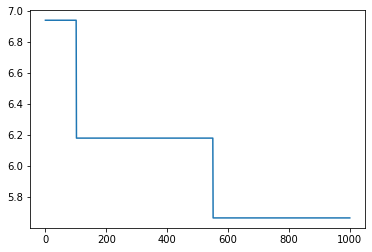

In [ ]:
plt.plot(v[:,0])

In [ ]:
rtp = RTP.flatten('F')
T = int(rtp.shape[0]-288)

In [ ]:
print(rtp[0:12])

[ 6.24  6.27  6.53  8.39 10.63 10.63  7.6   4.75  4.47  3.43  3.91  4.86]


In [ ]:
print(vH.shape)

(1, 8737)


In [ ]:
  print(v[:, 0])

[6.93888889 6.93888889 6.93888889 ... 5.664      5.664      5.664     ]


In [ ]:
eS = np.zeros(T) # generate the SoC series
pS = np.zeros(T) # generate the power series
e = 0.5
m=0
day = int(24/Ts)
for t in range(T):
  vv = vH[:, int(np.floor(m+1))]
  e, p = ArbValue(rtp[t+day], vv, e, P, 1, eta, c, vH.shape[0])
  eS[t] = e
  pS[t] = p
  m+=Ts
ProfitOutTest = np.sum(pS * rtp[day:T+day]) - np.sum(c * pS[pS>0])
RevenueTest = np.sum(pS * rtp[day:T+day])

In [ ]:
print("Profit: ", round(ProfitOutTest))
print("Revenue: ", round(RevenueTest))

Profit:  10103
Revenue:  13775


## using evaluate function

In [ ]:
evaluate_using_v_hr(rtp, vH, eta, c, T_CNN,
                    e0, Pr=Pr, Ts=Ts)

Profit:  20747
Revenue:  25984


20747.20387345679